In [359]:
# Standard Library Imports
import os
from io import BytesIO
import zipfile

# Third-Party Library Imports 
import category_encoders as ce
import matplotlib.pyplot as plt
import pandas as pd
import requests
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

### Retrieve data from a URL, unzip it, and load it into a DataFrame. The data is obtained from https://archive.ics.uci.edu/dataset/20/census+income.

In [360]:
# URL of the ZIP file
url = 'https://archive.ics.uci.edu/static/public/20/census+income.zip'

# Download the ZIP file
response = requests.get(url)
zip_content = BytesIO(response.content)

# Extract the ZIP files
with zipfile.ZipFile(zip_content, 'r') as zip_ref:
    zip_ref.extractall("data_census")

# Path to the CSV file within the extracted directory
csv_file = 'data_census/adult.data'

# Load the CSV file into a DataFrame
df = pd.read_csv(csv_file, header=None)

# Display the first 5 rows of the DataFrame
df.sample(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
16529,23,Private,170070,12th,8,Never-married,Other-service,Not-in-family,White,Female,0,0,38,United-States,<=50K
14930,32,Local-gov,203849,Some-college,10,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K
19562,55,Private,205422,10th,6,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,40,United-States,<=50K
14686,30,Private,53285,HS-grad,9,Married-civ-spouse,Sales,Husband,White,Male,0,0,52,United-States,>50K
22707,17,Local-gov,170916,10th,6,Never-married,Protective-serv,Own-child,White,Female,0,1602,40,United-States,<=50K


In [361]:
# Rename the columns to the correct names
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
                'marital-status', 'occupation', 'relationship', 'race', 'sex',
                'capital-gain', 'capital-loss', 'hours-per-week',
                'native-country', 'income']

# assigning columns to dataframe
df.columns = column_names

# Sample of the dataframe
df.sample(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
14080,33,Private,106938,HS-grad,9,Married-civ-spouse,Tech-support,Wife,Black,Female,0,0,38,United-States,<=50K
32511,25,Local-gov,514716,Bachelors,13,Never-married,Adm-clerical,Own-child,Black,Female,0,0,40,United-States,<=50K
6842,41,Private,51506,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,<=50K
2755,24,Private,211345,Some-college,10,Never-married,Other-service,Own-child,White,Female,0,0,40,Mexico,<=50K
375,20,Local-gov,350845,Some-college,10,Never-married,Adm-clerical,Own-child,White,Female,0,0,10,United-States,<=50K


### Pre-procesing data

In [362]:
# Function to delete spaces
strip_spaces = lambda x: x.strip() if type(x) == str else x

# Apply the function to the dataframe
df = df.map(strip_spaces)

In [363]:
# Verify null data
df.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

There aren´t null data 

In [364]:
# How much values there or per category in income
df['income'].value_counts()

income
<=50K    24720
>50K      7841
Name: count, dtype: int64

As we can see, our target column has more data for individuals with an annual income less than or equal to $50K. This could potentially introduce bias into our model during classification. Therefore, we will start by applying undersampling

In [365]:
# Split the DataFrame into two subsets
df_50K_or_less = df[df['income'] == '<=50K']  # Subset with income <= $50K
df_more_than_50K = df[df['income'] == '>50K']  # Subset with income > $50K

# Determine which subset is smaller
min_size = min(len(df_50K_or_less), len(df_more_than_50K))

# Perform undersampling on the larger subset to balance the classes
df_50K_or_less = df_50K_or_less.sample(n=min_size)  # Randomly sample to match the smaller size
df_more_than_50K = df_more_than_50K.sample(n=min_size)  # Randomly sample to match the smaller size

# Combine the two subsets into a new DataFrame with balanced classes
df = pd.concat([df_50K_or_less, df_more_than_50K])

# The resulting DataFrame now contains an equal number of samples for each income class

In [366]:
# Verify there are the same number of values per category
df['income'].value_counts()

income
<=50K    7841
>50K     7841
Name: count, dtype: int64

With our dataframe now balanced, the next step is to convert all columns into numeric data

In [367]:
# Find columns with string data types
# 'include=['object']' selects columns that are of the object type, typically strings in pandas
cols_to_encode = df.select_dtypes(include=['object']).columns

# Create an ordinal encoder for the found columns
# 'ce.OrdinalEncoder' is used to convert categorical text data into ordinal numerical format
encoder = ce.OrdinalEncoder(cols=cols_to_encode)

# Fit the encoder and transform the training data
# 'fit_transform' first fits the encoder to the training data, then transforms the training data
df_encoder = encoder.fit_transform(df)
df_encoder.sample(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
24230,51,6,133336,8,14,2,3,2,1,1,15024,0,40,1,2
10946,29,1,135296,2,11,1,4,4,1,2,0,0,40,1,1
8711,67,4,127543,13,6,2,8,2,1,1,2414,0,80,1,1
25627,44,1,222596,1,9,3,11,1,1,1,0,0,50,1,2
4322,35,1,202027,3,13,3,10,1,1,1,27828,0,50,1,2


### Training the model

Now that all the data has been converted into numeric values, it's time to split the data into training and testing sets

In [368]:
# Separate the target variable from the feature data
x = df_encoder.drop(['income'], axis=1)  # Features (independent variables)
y = df_encoder['income']  # Target variable (dependent variable)

# Split the data into training (70%) and testing (30%) sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)

# The data is now divided into training and testing sets for machine learning modeling

Now all is ready to train the model

In [369]:
# Create the decision tree model with a maximum depth of 7 and a random seed of 0
tree = DecisionTreeClassifier(max_depth=7, random_state=0)

# Train the model using the training data
tree.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=7, random_state=0)

## Evaluate the model

In [370]:
# Calculate predictions of the model for the data of train and test
y_train_pred_tree = tree.predict(x_train)
y_test_pred_tree = tree.predict(x_test)

#### Metrics

In [371]:
# Calculate the accuracy on the training set
train_accuracy_tree = accuracy_score(y_train, y_train_pred_tree)

# Calculate the accuracy on the testing set
test_accuracy_tree = accuracy_score(y_test, y_test_pred_tree)

# Print the accuracy results for both training and testing sets
print('Accuracy on the training set:', train_accuracy_tree)
print('Accuracy on the testing set:', test_accuracy_tree)

Accuracy in train: 0.8246333242233761
Accuracy in test: 0.8119022316684378


The results for train and test are really similar this is good beacuse that mean the model doesn´t have overfiting

#### Lets see what is most important features for the predict

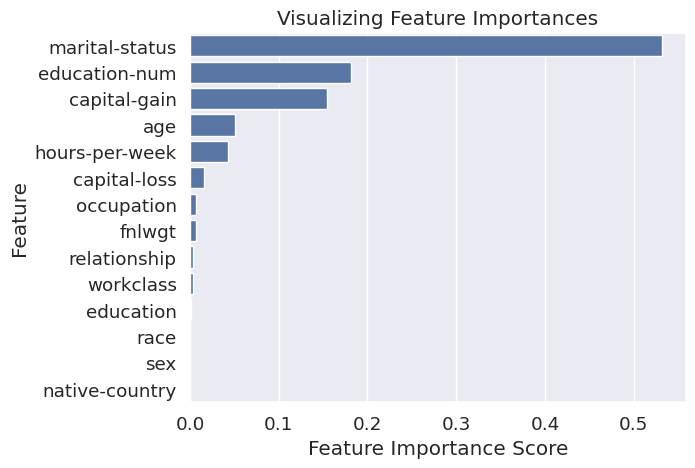

In [375]:
# Visualize the feature importances

# Calculate feature importances and sort them in descending order
features_scores = pd.Series(tree.feature_importances_, index=x_train.columns).sort_values(ascending=False)

# Create a bar plot to visualize feature importances
sns.barplot(x=features_scores, y=features_scores.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature')
plt.title("Visualizing Feature Importances")
plt.show()

It's interesting to note that the most important feature is marital status. This suggests that we should consider conducting a study to explore how different marital statuses correlate with income levels

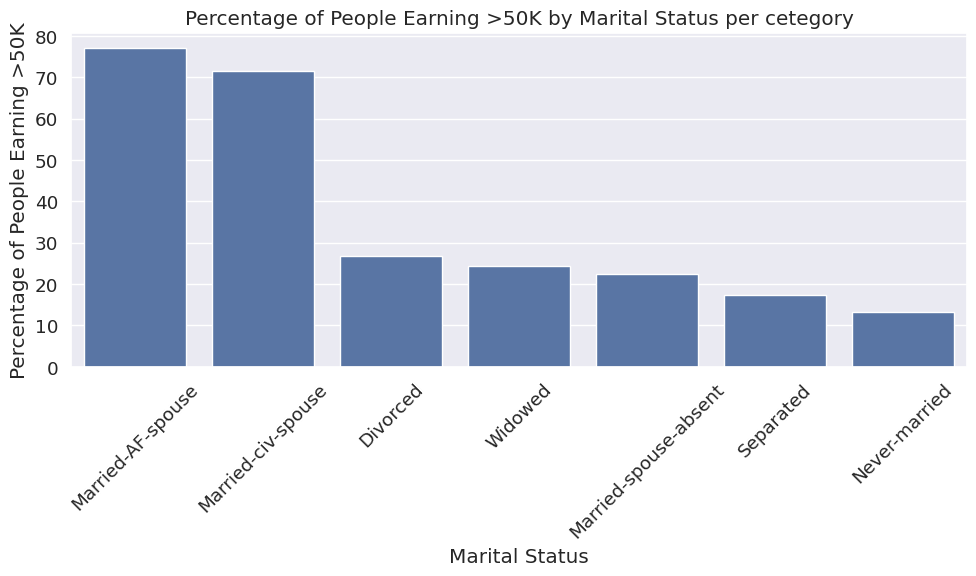

In [373]:
# Calculate the percentage of people earning more than 50K by marital status
# First, count the total number of people for each marital status
total_counts = df['marital-status'].value_counts()

# Then, count the number of people earning more than 50K for each marital status
over_50k_counts = df[df['income'] == '>50K']['marital-status'].value_counts()

# Calculate the percentage of people earning more than 50K by marital status
percentage_over_50k = (over_50k_counts / total_counts * 100).sort_values(ascending=False)

# Create a bar chart with the percentages
plt.figure(figsize=(10, 6))
sns.barplot(x=percentage_over_50k.index, y=percentage_over_50k.values)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Set the title and labels
plt.title('Percentage of People Earning >50K by Marital Status per Category')
plt.xlabel('Marital Status')
plt.ylabel('Percentage of People Earning >50K')

# Display the chart
plt.tight_layout()
plt.show()


This graphic displays the total data for each category and indicates the percentage of individuals with an annual income exceeding 50K. It's noteworthy that married individuals tend to have higher incomes compared to those with other marital statuse

Let's take a look at the confusion matrix.

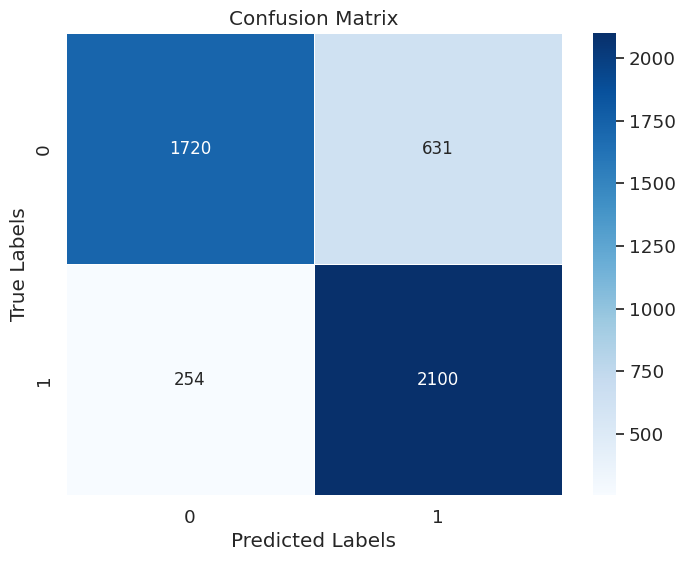

In [374]:
# Matrix of confusion whit the results
cm = confusion_matrix(y_test,y_test_pred_tree)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font size if needed
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=.5, annot_kws={"size": 12})

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.show()


Overall, the model was able to correctly evaluate individuals earning more than 50K. While there were some errors for those who don't, the percentage of errors remains relatively low, indicating good overall results.